# Project

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Social Media Analytics
- Course ID: BDA600NAA.07578.2241
- Professor: Dr. Pantea Koochemeshkian


## Tasks
1. Use charts (histogram/bar graph) to display the distribution of types of statuses (photo, video, link, and status). 
   
2. Plot a chart showing the progression of likes, loves, and sads, and angrys over time. 
   
3. What are the top reactions expressed by Trump’s Facebook audience? 
   
4. Analyze the content in the status_message to find the top 10 topics (Topic modeling LDA can be used). Can you tell if fans are particularly happy or upset about the topics?  
   
5. What are the themes (topics or top words) that generated a lot of shares? 
   
6. What are the themes (topics or top words) that generated a lot of num_reactions? 

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import os
import re
from collections import Counter

import emoji
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from gensim.models import Word2Vec

In [2]:
# Load data
data = pd.read_csv('dataset.csv')
print(data.columns)
data.head()

Index(['status_id', 'status_message', 'link_name', 'status_type',
       'status_link', 'status_published', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys'],
      dtype='object')


,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


### 1. The distribution of types of statuses

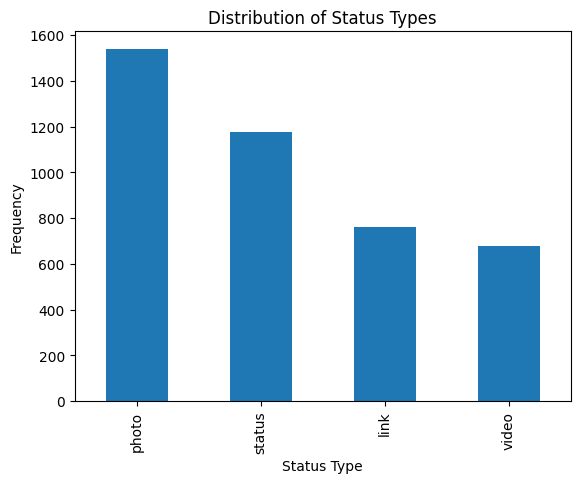

In [3]:
# Count the frequency of each status type
status_lst = ['photo', 'video', 'link', 'status']
status_data = data[data['status_type'].isin(status_lst)]
status_counts = status_data['status_type'].value_counts().sort_values(ascending=False)

# Plot the distribution of status types
status_counts.plot(kind='bar')
plt.title('Distribution of Status Types')
plt.xlabel('Status Type')
plt.ylabel('Frequency')
plt.show()

### 2. Progression of reactions

In [4]:
# drop observation whose status_publish is missing
data = data.dropna(subset=['status_published'])
# drop an observation with an error
invalid_date_obs = data[pd.to_numeric(data['status_published'], errors='coerce').notnull()]
data = data.drop(invalid_date_obs.index)
# Ensure the date or timestamp column is in datetime format
data['status_published'] = pd.to_datetime(data['status_published'])
# Set the 'status_published' as the index
data.set_index('status_published', inplace=True)
# Resample data to get daily sums of reactions
daily_data = data.resample('D').sum()

Text(0.5, 0.98, 'Progression of Reactions Over Time')

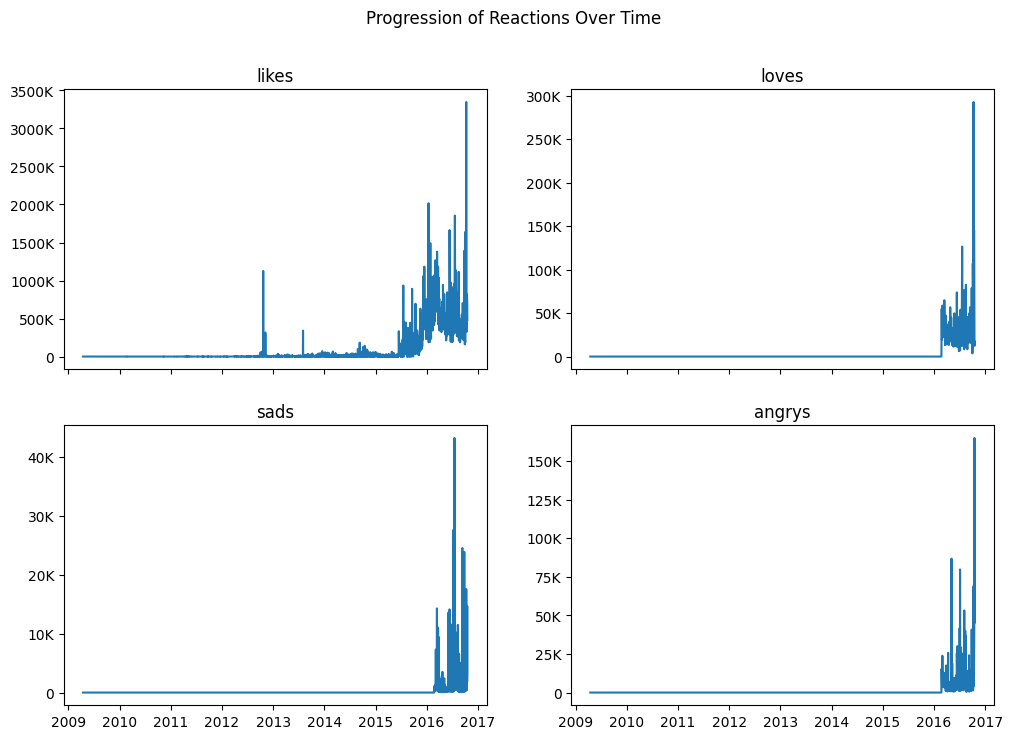

In [5]:
# Plotting the progression of likes, loves, sads, and angrys over time
col_names = ['num_likes', 'num_loves', 'num_sads', 'num_angrys']
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for i, col in enumerate(col_names):
    r, c = divmod(i, 2)
    ax[r][c].plot(daily_data.index, daily_data[col])
    ax[r][c].set_title(f'{col.split("_")[1]}')
    ax[r][c].get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:.0f}K".format(int(x)/1000) if x >= 1000 else "{:.0f}".format(int(x)))
    )

# Adding title and labels
fig.suptitle('Progression of Reactions Over Time')

### 3. Top reactions

In [6]:
# Sum the reactions to find the totals
total_reactions = data[['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']].sum()

# Sort the reactions to find the top ones
top_reactions = total_reactions.sort_values(ascending=False)

print(top_reactions)

num_likes     220675804.0
num_loves       7706060.0
num_angrys      2269144.0
num_hahas       1687935.0
num_wows         695274.0
num_sads         540292.0
dtype: float64


### 4. Text Preprocessing

In [71]:
# Drop out the observations whose 'status_message' is missing
#  and create data for LDA
data_ = data.dropna(subset=['status_message'])

# Cleaning the texts
def clean_texts(raw_texts: np.array, arbitrary_remove_words: list = []):
    # define result
    result = []

    # set of stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(set(arbitrary_remove_words))  # add more unnecessary words baed on observations 
    # initialize tweet tokenizer
    tweet_tokenizer = TweetTokenizer()
    # set the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # function to convert emojis to text
    def convert_emojis(text):
        return emoji.demojize(text, delimiters=("", ""))
    
    # function to get the wordnet pos
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        else:
            # Default to noun
            return wordnet.NOUN

    # traversing all sentences
    for sent in raw_texts:
        # (1): white space removal
        sent = sent.strip()
        # (2): URL removal
        sent = re.sub(r"http[s]?://[\w?\W?]+", ' ', sent)
        # (3): HTML tag removal
        sent = re.sub(r'<[^>]+>', ' ', sent)
        # (4): ordinal number removal
        sent = re.sub(r'\d+(st|nd|rd|th)', ' ', sent)
        # (5): Repeated words (at least four times)
        sent = re.sub(r'(.)\1{4,}', r'\1', sent)
        # (6): Punctuation removal
        sent = re.sub(r'[^\w\s]', ' ', sent)
        # (7): Emoji to text
        sent = convert_emojis(sent)
        # (8): lemmatizaiton & tokenization
        token = tweet_tokenizer.tokenize(sent)
        tagged_token = nltk.pos_tag(token)
        lemma_token = [
            lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1]))
            for w in tagged_token
            # adjective ('JJ', 'JJR', 'JJS'), noun ('NN', 'NNP', 'NNS', 'NNPS'), verbs ('VB', 'VBD', 'VBG', 'VBN', 'VBP')
            if w[1] in ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
        ]
        # defined cleaned sentence
        clean_sent = ''
    
        # cleaning each sentence
        for w in lemma_token:
            # if 'w' is one of stop words or length of wrods are less than 3, skip to the next word
            if w.lower() in stop_words or len(w) < 3:
                continue
            # add words
            clean_sent += w.lower() + ' '

        # add clean_sent to result (make sure that the last item is always blank)
        result += [clean_sent[:-1]]

    return result

# Define arbitrary removed words from observatinos
remove_words = ['cannot', 'com']
# Get the clean status message data as list
sent_list = clean_texts(np.array(data_['status_message'].values), remove_words)

# Identify the NaN value after preprocessing
null_ids = [i for i, sent in enumerate(sent_list) if len(sent) == 0]

# Delete null data 
sent_list = [item for item in sent_list if item != '']
data_ = data_.reset_index()
data_ = data_.drop(null_ids).reset_index(drop=True)

### Topic Modeling GMM Approach

In [73]:
# Define a nested list; each item is a list of word on each status message
corpus = [s.split() for s in sent_list]

# train or load cbow model
def load_cbow_model(model_path, corpus):
    # Check if the model already exists
    if os.path.exists(model_path):
        # Load the existing model
        print("Loading existing CBOW model from", model_path)
        cbow_model = Word2Vec.load(model_path)
    else:
        # Train a Word2Vec model (continous bag-of-words model)
        #  window size = 11 -> consider the left and right context of 5 words
        print("Training new CBOW model.")
        cbow_model = Word2Vec(corpus, vector_size=100, window=11, min_count=1, sg=0)
        # Save the newly trained model
        cbow_model.save(model_path)
        print("Saved the trained CBOW model to", model_path)

    return cbow_model

# execute function
model_path = 'cbow_model.bin'
cbow_model = load_cbow_model(model_path, corpus)

Training new CBOW model.
Saved the trained CBOW model to cbow_model.bin


In [96]:
# Convert word to vector
def word_to_vector(corpus: list, cbow_model: Word2Vec):
    # Define output; context representationas
    context_reps = []

    # Traverse each message
    for message in corpus:
        # Decine weights for each word in message
        weights = np.ones(len(message))
        # Collection of word vectors on each message
        vectors = []
        for word in message:
            # Add converted word embeddings in the text to its vector representation
            vectors.append(cbow_model.wv[word])  

        # Calculate the weighted average of word embeddings for each message.
        avg_vec = np.mean(np.array([w * v for w, v in zip(weights, vectors)]), axis=0)
        # Add to context representations
        context_reps.append(avg_vec)

    return np.array(context_reps)

# Create message vectors for each text
message_vec = word_to_vector(corpus, cbow_model)

In [97]:
# Specify 10 topics
n_comps = 10

# Initialize the GMM
gmm = GaussianMixture(n_components=n_comps, random_state=0)

# Fit the model
gmm.fit(message_vec)

# Assign message to topics
topics = gmm.predict(message_vec)

# get counts of each topics
pd.DataFrame(topics).value_counts()

7    916
8    629
6    491
4    402
0    352
2    295
1    249
9    171
3    169
5    109
Name: count, dtype: int64

### Topic Analysis

===== Display the most frequent words on each topic =====
Topic 0: florida, remember, strong, tomorrow, rally, tuesday, wow, important, future, number, caucus, incredible, question, hampshire, evening
Topic 1: something, nomination, happy, raise, college, book, veterans, meeting, peace, able, discuss, move, beautiful, convention, gopdebate
Topic 2: carolina, makeamericagreatagain, start, let, south, ivanka, amazing, proud, caucus, wonderful, evening, history, continue, general, fox
Topic 3: easy, rich, texas, dream, aircraft, smart, amaze, doral, may, available, wife, welcome, monday, rnc, clear
Topic 4: happen, become, lot, word, fox, continue, history, send, ask, part, high, israel, share, senator, build
Topic 5: nadauld, match, pizza, schedule, link, finance, buffalo, leisure, veteranreform, globalism, non, honesty, design, indicate, technology
Topic 6: check, top, sign, event, melania, endorsement, force, home, former, large, house, yesterday, case, tough, massive
Topic 7: let, ama

C:\Users\runru\AppData\Local\Temp\ipykernel_23172\2405014797.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


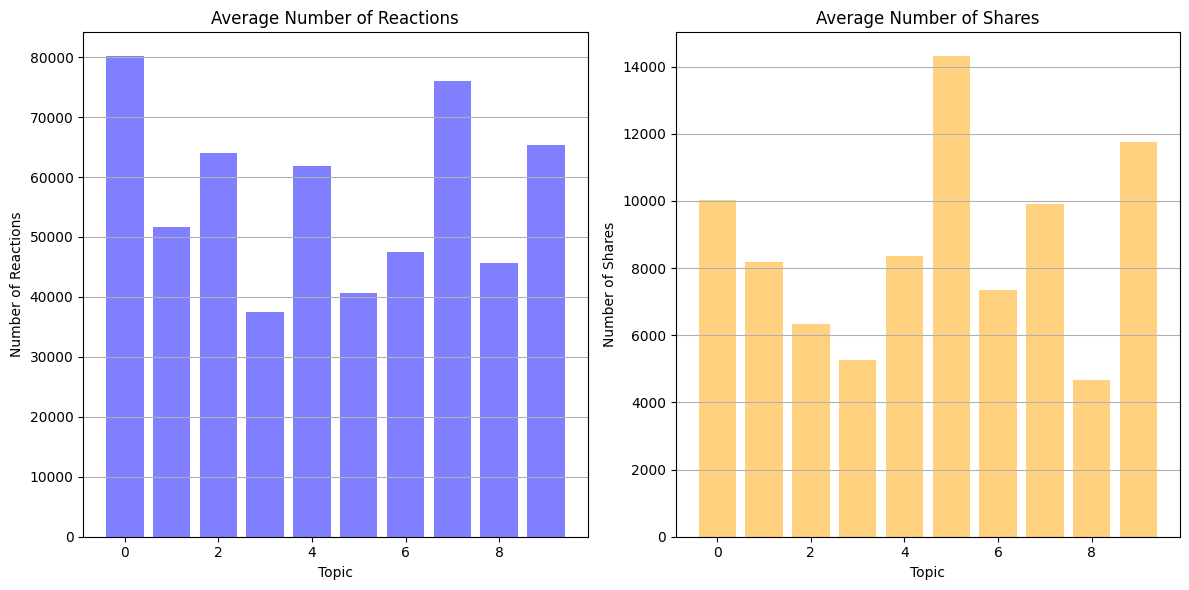

In [92]:
# Copy with only necessary columns
data_new = data_[['num_reactions', 'num_shares']].copy()
# Assign the predicted topic as new column "topic"
data_new['topic'] = topics

def topic_analysis(df, cbow_model, gmm_model, top_freq_words=15):
    # Get unique words in corpus
    words = list(cbow_model.wv.key_to_index.keys())
    # Retrieve vector for each word
    embeddings = np.array([cbow_model.wv[word] for word in words])
    # Get the cluster_centers of each component in the GMM
    cluster_centers = gmm_model.means_
    # Calculate the distance of each word vector from each GMM component mean
    distances = np.array([np.linalg.norm(embeddings - mean, axis=1) for mean in cluster_centers])
    # For each topic, find words with the smallest distance to the component mean
    topic_words = {}
    for i, topic_dist in enumerate(distances):
        sorted_indices = np.argsort(topic_dist)
        # Get top 10 words for the topic
        topic_words[f'Topic {i}'] = [words[idx] for idx in sorted_indices[:top_freq_words]]

    print("===== Display the most frequent words on each topic =====")
    for topic, words in topic_words.items():
        print(f'{topic}: {", ".join(words)}')
    print("")

    print("===== Show the average number of reactions and shares on each topic=====")
    # Generate data frame
    df_v2 = df.groupby(['topic']).mean()
    # Display the result
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting num_reactions
    ax[0].bar(df_v2.index, df_v2['num_reactions'], color='blue', alpha=0.5)
    ax[0].set_title('Average Number of Reactions')
    ax[0].set_xlabel('Topic')
    ax[0].set_ylabel('Number of Reactions')
    ax[0].yaxis.grid(True)

    # Plotting num_shares
    ax[1].bar(df_v2.index, df_v2['num_shares'], color='orange', alpha=0.5)
    ax[1].set_title('Average Number of Shares')
    ax[1].set_xlabel('Topic')
    ax[1].set_ylabel('Number of Shares')
    ax[1].yaxis.grid(True)

    # Adjust the subplots to fit into the figure area.
    fig.tight_layout()

    # Display the plot
    fig.show()

topic_analysis(data_new, cbow_model, gmm)

### Model Evaluation

In [93]:
def model_evaluation(gmm_model, input_vec, pred_topics):
    """
    Evaluate the topic modeling
    
    Parameters:
    - gmm_model: the trained Gaussian Mixture Model
    - input_vec: the context representation (aggregated word embeddings for each message)
    - pred_topics: the predited or classified topics

    """

    ##### Define visualization figure
    print("===== Visualize the Topic Modeling Performance =====")
    fig, ax = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle("Topic Modeling Performance")

    ### (1): Within-cluster distance
    # Get number of clusters and storage for within-cluster distance
    cluster_centers = gmm_model.means_
    n_clusters = len(cluster_centers)
    cluster_dist = [[] for _ in range(n_clusters)]
    # Calculate the distance from each point to its cluster center
    for point, topic in zip(input_vec, pred_topics):
        center = cluster_centers[topic-1]
        distance = np.linalg.norm(point - center)
        cluster_dist[topic].append(distance)
    # Calculate the average and standard deviation of distance for each cluster
    avg_dist = [round(np.mean(d), 2) for d in cluster_dist]
    std_dist = [round(np.std(d), 2) for d in cluster_dist]
    # Count occurrences of each category
    topic_counts = Counter(topics)
    topic_counts_dict = dict(topic_counts)

    # Plot visualization
    legend_circle = Line2D([0], [0], marker='o', ls='none', color='blue', markersize=10, alpha=0.3)
    error = ax[0].errorbar([i for i in range(10)], avg_dist, yerr=std_dist, fmt='o', capsize=5, color='grey')
    scatter = ax[0].scatter([i for i in range(10)], avg_dist, s=[topic_counts_dict[i] for i in range(10)], alpha=0.3, color='blue')

    # Adding lagend, labels, title
    ax[0].legend(handles=[legend_circle, error], labels=['Data Size', 'Mean & Std'])
    ax[0].set_xlabel('Topics')
    ax[0].set_ylabel('Distance')
    ax[0].set_title('Within-cluster Distance')
    

    ### (2): in-between cluster distance
    # Calculate distance among every pair of clusters
    distance_matrix = pairwise_distances(gmm_model.means_, gmm_model.means_)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

    # Display the heatmap with the mask
    sns.heatmap(distance_matrix, mask=mask, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Distance'}, ax=ax[1])
    # Set metadata in the plot
    ax[1].set_title('Distance Matrix Between Cluster Centers')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Cluster')
    

    ### (3): Plot distribution of context representation
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(message_vec)
    # get 2D version cluster center
    cluster_centers_2d = pca.transform(cluster_centers)

    # Plot each point and color it based on its cluster assignment
    ax[2].scatter(data_2d[:, 0], data_2d[:, 1], c=topics, cmap='viridis', zorder=1, alpha=0.5)

    # Plot the cluster centers
    ax[2].scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], s=300, c='red', zorder=2)

    # Plot the ellipses representing the cluster variances
    for i, (mean, covar) in enumerate(zip(cluster_centers_2d, gmm_model.covariances_)):
        v, w = np.linalg.eigh(covar[:2, :2])  # Extract the top 2 eigenvalues/vectors for 2D
        v = 2. * np.sqrt(2.) * np.sqrt(v)  # Scale factor for the ellipses
        u = w[0] / np.linalg.norm(w[0])
        
        # Add an ellipse for each cluster center
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # Convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='blue')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        ax[2].add_artist(ell)

        # Add the cluster index as text near the cluster center
        ax[2].text(mean[0], mean[1], str(i), color='white', ha='center', va='center', fontweight='bold', zorder=3)

    # Add title and labels
    ax[2].set_title('GMM Clustering with PCA Visualization')
    ax[2].set_xlabel('PCA Component 1')
    ax[2].set_ylabel('PCA Component 2')
    print("")

    fig.show()

===== Visualize the Topic Modeling Performance =====


C:\Users\runru\AppData\Local\Temp\ipykernel_23172\2619157487.py:82: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='blue')
C:\Users\runru\AppData\Local\Temp\ipykernel_23172\2619157487.py:96: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


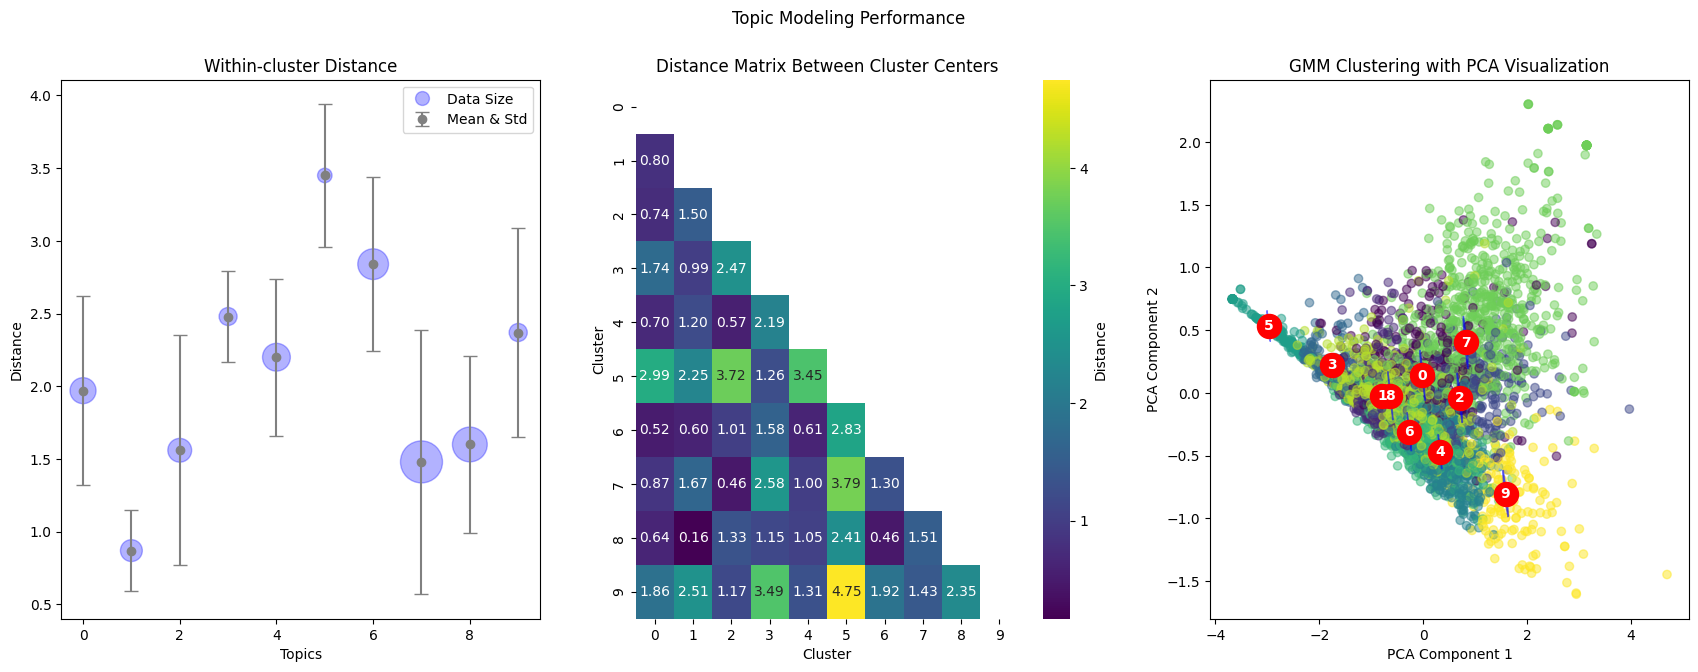

In [94]:
model_evaluation(gmm, message_vec, topics)